# Advanced RAG: Query Expansion
_by Tuana Celik ([LI](https://www.linkedin.com/in/tuanacelik/),  [Twitter/X](https://x.com/tuanacelik))_

> This is part one of the **Advanced Use Cases** series:
>
> 1️⃣ Extract Metadata from Queries to Improve Retrieval [cookbook](/cookbook/extracting_metadata_filters_from_a_user_query) & [full article](/blog/extracting-metadata-filter)
>
> 2️⃣ **Query Expansion & the [full article](/blog/query-expansion)**
>
> 3️⃣ Query Decomposition [cookbook](/cookbook/query_decomposition) & [full article](/blog/query-decomposition)
>
> 4️⃣ [Automated Metadata Enrichment](/cookbook/metadata_enrichment)

In this cookbook, you'll learn how to implement query expansion for RAG. Query expansion consists of asking an LLM to produce a number of similar queries to a user query. We are then able to use each of these queries in the retrieval process, increasing the number and relevance of retrieved documents.

📚 [Read the full article](https://haystack.deepset.ai/blog/query-expansion)

In [ ]:
!pip install haystack-ai wikipedia

In [20]:
import wikipedia
import json

from typing import List, Optional
from haystack import Pipeline, component

from haystack.components.builders import ChatPromptBuilder
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.retrievers import InMemoryBM25Retriever
from haystack.components.writers import DocumentWriter

from haystack.dataclasses import ChatMessage, Document

from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.document_stores.types import DuplicatePolicy

In [10]:
import os
from getpass import getpass

if "OPENAI_API_KEY" not in os.environ:
  os.environ['OPENAI_API_KEY'] = getpass("Your OpenAI API Key: ")

## The Process of Query Expansion

First, let's import the `QueryExpander` from **Haystack Experimental**.

Next, we’ll create a `QueryExpander` instance. This component generates a specified number (default is 4) of additional queries that are similar to the original user query. It returns `queries`, which include the original query plus the generated similar ones.

In [4]:
from haystack_experimental.components.query.query_expander import QueryExpander

In [6]:
expander = QueryExpander()
expander.run(query="open source nlp frameworks", n_expansions=4)

{'queries': ['natural language processing tools',
  'free nlp libraries',
  'open-source NLP platforms',
  'public domain language processing frameworks',
  'open source nlp frameworks']}

## Retrieval Without Query Expansion

In [11]:
documents = [
    Document(content="The effects of climate are many including loss of biodiversity"),
    Document(content="The impact of climate change is evident in the melting of the polar ice caps."),
    Document(content="Consequences of global warming include the rise in sea levels."),
    Document(content="One of the effects of environmental changes is the change in weather patterns."),
    Document(content="There is a global call to reduce the amount of air travel people take."),
    Document(content="Air travel is one of the core contributors to climate change."),
    Document(content="Expect warm climates in Turkey during the summer period."),
]

doc_store = InMemoryDocumentStore(embedding_similarity_function="cosine")
doc_store.write_documents(documents)

retriever = InMemoryBM25Retriever(document_store=doc_store, top_k=3)

retrieval_pipeline = Pipeline()
retrieval_pipeline.add_component("keyword_retriever", retriever)

In [12]:
query = "climate change"
retrieval_pipeline.run({"keyword_retriever":{ "query": query, "top_k": 3}})

{'keyword_retriever': {'documents': [Document(id=8b306c8303c59508a53e5139b4e688c3817fa0211b095bcc77ab3823defa0b32, content: 'Air travel is one of the core contributors to climate change.', score: 2.023895027544814),
   Document(id=aa996058ca5b30d8b469d33e992e094058e707bfb0cf057ee1d5b55ac4320234, content: 'The impact of climate change is evident in the melting of the polar ice caps.', score: 1.8661960327485192),
   Document(id=4d5f7ef8df12c93cb5728cc0247bf95282a14017ce9d0b35486091f8972347a5, content: 'The effects of climate are many including loss of biodiversity', score: 1.5532314806726806)]}}

## Retrieval With Query Expansion

Now let's have a look at what documents we are able to retrieve if we are to inluce query expansion in the process. For this step, let's create a `MultiQueryInMemoryBM25Retriever` that is able to use BM25 retrieval for each (expansded) query in turn.

This component also handles the same document being retrieved for multiple queries and will not return duplicates.

In [13]:
@component
class MultiQueryInMemoryBM25Retriever:

    def __init__(self, retriever: InMemoryBM25Retriever, top_k: int = 3):
        self.retriever = retriever
        self.top_k = top_k

    @component.output_types(documents=List[Document])
    def run(self, queries: List[str], top_k: int = None):
        if top_k != None:
            self.top_k = top_k

        all_docs = {}
        for query in queries:
            result = self.retriever.run(query = query, top_k = self.top_k)
            for doc in result['documents']:
                all_docs[doc.id] = doc

        all_docs = list(all_docs.values())
        all_docs.sort(key=lambda x: x.score, reverse=True)
        return {"documents": all_docs}

In [14]:
query_expander = QueryExpander()
retriever = MultiQueryInMemoryBM25Retriever(InMemoryBM25Retriever(document_store=doc_store))

expanded_retrieval_pipeline = Pipeline()
expanded_retrieval_pipeline.add_component("expander", query_expander)
expanded_retrieval_pipeline.add_component("keyword_retriever", retriever)

expanded_retrieval_pipeline.connect("expander.queries", "keyword_retriever.queries")

🚅 Components
  - expander: QueryExpander
  - keyword_retriever: MultiQueryInMemoryBM25Retriever
🛤️ Connections
  - expander.queries -> keyword_retriever.queries (List[str])

In [15]:
expanded_retrieval_pipeline.run({"expander": {"query": query}}, include_outputs_from=["expander"])

{'expander': {'queries': ['global warming',
   'environmental climate shifts',
   "changes in Earth's climate",
   'effects of climate variability',
   'climate change']},
 'keyword_retriever': {'documents': [Document(id=0901b034998c7263f74ac60cad5d9d520df524e59b045f3afab8e6cf1710791d, content: 'Consequences of global warming include the rise in sea levels.', score: 3.5574227469366644),
   Document(id=40fcd5a4a3670b7e105db664783c076167bb699cade9aa7fd6d409fac2efb49e, content: 'There is a global call to reduce the amount of air travel people take.', score: 2.409793821666657),
   Document(id=395d2da61fff546098eec2838da741033d71fef84dfa7a91fc40b1d275631933, content: 'One of the effects of environmental changes is the change in weather patterns.', score: 2.185936012403085),
   Document(id=8b306c8303c59508a53e5139b4e688c3817fa0211b095bcc77ab3823defa0b32, content: 'Air travel is one of the core contributors to climate change.', score: 2.023895027544814),
   Document(id=aa996058ca5b30d8b469d33

## Query Expansion for RAG

Let's start off by populating a document store with chunks of context from various Wikipedia pages.

In [16]:
def get_doc_store():
    raw_docs = []
    wikipedia_page_titles = ["Electric_vehicle", "Dam", "Electric_battery", "Tree", "Solar_panel", "Nuclear_power",
                             "Wind_power", "Hydroelectricity", "Coal", "Natural_gas", "Greenhouse_gas", "Renewable_energy",
                             "Fossil_fuel"]
    for title in wikipedia_page_titles:
        page = wikipedia.page(title=title, auto_suggest=False)
        doc = Document(content=page.content, meta={"title": page.title, "url": page.url})
        raw_docs.append(doc)

    doc_store = InMemoryDocumentStore(embedding_similarity_function="cosine")

    indexing_pipeline = Pipeline()
    indexing_pipeline.add_component("cleaner", DocumentCleaner())
    indexing_pipeline.add_component("splitter", DocumentSplitter(split_by="passage", split_length=1))
    indexing_pipeline.add_component("writer", DocumentWriter(document_store=doc_store, policy=DuplicatePolicy.SKIP))
    indexing_pipeline.connect("cleaner", "splitter")
    indexing_pipeline.connect("splitter", "writer")

    indexing_pipeline.run({"cleaner": {"documents": raw_docs}})

    return doc_store

In [17]:
doc_store = get_doc_store()

### RAG without Query Expansion

In [23]:
chat_message = ChatMessage.from_user(
    text="""You are part of an information system that summarises related documents.
You answer a query using the textual content from the documents retrieved for the
following query.
You build the summary answer based only on quoting information from the documents.
You should reference the documents you used to support your answer.
###
Original Query: "{{query}}"
Retrieved Documents: {{documents}}
Summary Answer:
"""
)
retriever = InMemoryBM25Retriever(document_store=doc_store)
chat_prompt_builder = ChatPromptBuilder(template=[chat_message], required_variables="*")
llm = OpenAIChatGenerator()

keyword_rag_pipeline = Pipeline()
keyword_rag_pipeline.add_component("keyword_retriever", retriever)
keyword_rag_pipeline.add_component("chat_prompt_builder", chat_prompt_builder)
keyword_rag_pipeline.add_component("llm", llm)

keyword_rag_pipeline.connect("keyword_retriever.documents", "chat_prompt_builder.documents")
keyword_rag_pipeline.connect("chat_prompt_builder.prompt", "llm.messages")

🚅 Components
  - keyword_retriever: InMemoryBM25Retriever
  - chat_prompt_builder: ChatPromptBuilder
  - llm: OpenAIChatGenerator
🛤️ Connections
  - keyword_retriever.documents -> chat_prompt_builder.documents (List[Document])
  - chat_prompt_builder.prompt -> llm.messages (List[ChatMessage])

In [24]:
keyword_rag_pipeline.run({"query": "green energy sources", "top_k": 3}, include_outputs_from=["keyword_retriever"])

{'keyword_retriever': {'documents': [Document(id=b5544970917394145729c23e6447d57ca42aad99fd68d17641682b4726b326b5, content: 'Renewable energy (also called green energy) is energy made from renewable natural resources that are...', meta: {'title': 'Renewable energy', 'url': 'https://en.wikipedia.org/wiki/Renewable_energy', 'source_id': '2089cf2a38231b23fe28c73d1b8c847fdb84190acf6ea60fac87c733fad5694d', 'page_number': 1, 'split_id': 0, 'split_idx_start': 0}, score: 2.5931591814370085),
   Document(id=30a6ac048f1c1b62b11b64b08bc62a416e26751a0209718426970a03279aa4f0, content: 'Wind power is the use of wind energy to generate useful work. Historically, wind power was used by s...', meta: {'title': 'Wind power', 'url': 'https://en.wikipedia.org/wiki/Wind_power', 'source_id': 'bf171fa3a08865668abc6b95bfa89aeeef6520aa05263e2c3166121553262c41', 'page_number': 1, 'split_id': 0, 'split_idx_start': 0}, score: 2.1698503702912926),
   Document(id=6111c991130070bb618386d1028eaabe822aacec6c6d971570856

### RAG with Query Expansion

In [25]:
chat_message = ChatMessage.from_user(
    text="""You are part of an information system that summarises related documents.
You answer a query using the textual content from the documents retrieved for the
following query.
You build the summary answer based only on quoting information from the documents.
You should reference the documents you used to support your answer.
###
Original Query: "{{query}}"
Retrieved Documents: {{documents}}
Summary Answer:
"""
)
query_expander = QueryExpander()
retriever = MultiQueryInMemoryBM25Retriever(InMemoryBM25Retriever(document_store=doc_store))
chat_prompt_builder = ChatPromptBuilder(template=[chat_message], required_variables="*")
llm = OpenAIChatGenerator()

query_expanded_rag_pipeline = Pipeline()
query_expanded_rag_pipeline.add_component("expander", query_expander)
query_expanded_rag_pipeline.add_component("keyword_retriever", retriever)
query_expanded_rag_pipeline.add_component("chat_prompt_builder", chat_prompt_builder)
query_expanded_rag_pipeline.add_component("llm", llm)

query_expanded_rag_pipeline.connect("expander.queries", "keyword_retriever.queries")
query_expanded_rag_pipeline.connect("keyword_retriever.documents", "chat_prompt_builder.documents")
query_expanded_rag_pipeline.connect("chat_prompt_builder.prompt", "llm.messages")

🚅 Components
  - expander: QueryExpander
  - keyword_retriever: MultiQueryInMemoryBM25Retriever
  - chat_prompt_builder: ChatPromptBuilder
  - llm: OpenAIChatGenerator
🛤️ Connections
  - expander.queries -> keyword_retriever.queries (List[str])
  - keyword_retriever.documents -> chat_prompt_builder.documents (List[Document])
  - chat_prompt_builder.prompt -> llm.messages (List[ChatMessage])

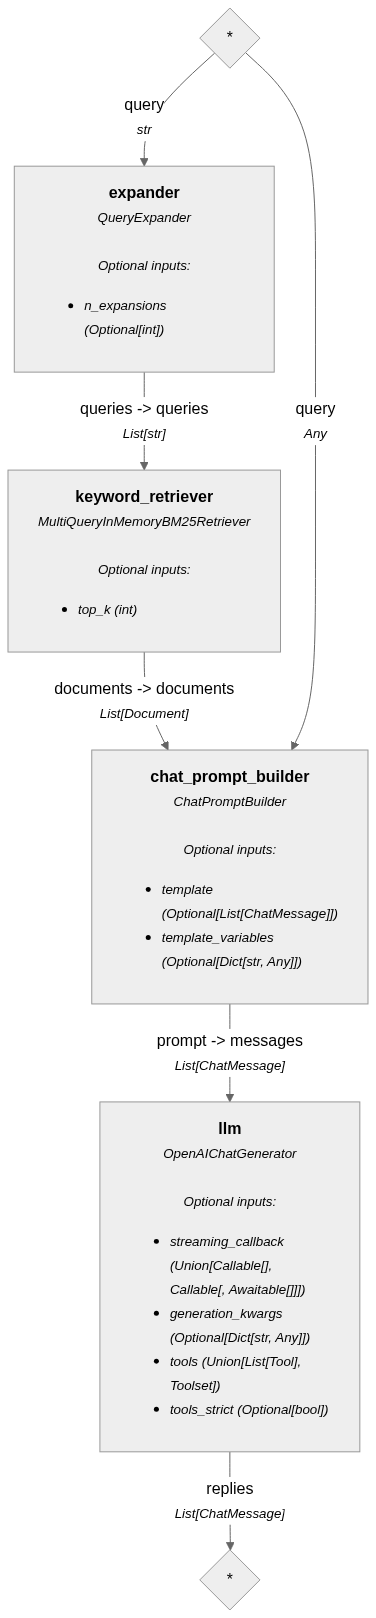

In [26]:
query_expanded_rag_pipeline.show()

In [27]:
query_expanded_rag_pipeline.run({"query": "green energy sources", "top_k": 3}, include_outputs_from=["keyword_retriever", "expander"])

{'expander': {'queries': ['renewable energy sources',
   'sustainable power generation',
   'eco-friendly energy options',
   'clean energy resources',
   'green energy sources']},
 'keyword_retriever': {'documents': [Document(id=bc480a9fbfd7d1e9bbd2deb6f714b6533a62673064f6d015b674b9121e128f67, content: 'An electric battery is a source of electric power consisting of one or more electrochemical cells wi...', meta: {'title': 'Electric battery', 'url': 'https://en.wikipedia.org/wiki/Electric_battery', 'source_id': '03300aed831e8407b7c7db4d7ead042d2c1c6858133809b03424185910318241', 'page_number': 1, 'split_id': 0, 'split_idx_start': 0}, score: 4.3266776407237),
   Document(id=219c74b79bdebd2288deb0846466baa963cc685d90b824f91d2e3c1b9788aec5, content: 'An electric vehicle (EV) is a motor vehicle whose propulsion is powered fully or mostly by electrici...', meta: {'title': 'Electric vehicle', 'url': 'https://en.wikipedia.org/wiki/Electric_vehicle', 'source_id': '3f37bb285d46a2d30be6f670e4ad2